# Gaussian Copula

El método Gaussian Copula destaca por su capacidad para modelar dependencias multivariadas entre variables, preservando la estructura estadística de los datos originales. Este enfoque se basa en la teoría de **cópulas**, que permite desacoplar las distribuciones marginales de las dependencias entre variables, ofreciendo flexibilidad para generar datos sintéticos realistas [[Zheng et al., 2020](https://arxiv.org/pdf/2009.09471)].

Las **cópulas** son funciones que vinculan distribuciones marginales univariadas para formar una distribución multivariada. El teorema de Sklar (1959) establece que cualquier distribución conjunta $H$ de variables aleatorias $(X_1,X_2,...,X_d)$ puede expresarse como:

```{math}
H(x_1,x_2,...,x_d)=C(F_1(x_1),F_2(x_2),...,F_d(d_d))
```

donde $C$ es la cópula y $F_i$ son las funciones de distribución marginal. La Gaussian Copula utiliza una cópula derivada de la distribución normal multivariada, definida como:

$$
C_\Sigma(\mathbf{u}) = \Phi_\Sigma \left( \Phi^{-1}(u_1), \Phi^{-1}(u_2), \dots, \Phi^{-1}(u_d) \right)
$$

donde:

 - $\Phi_\Sigma$: es la función de distribución normal multivariada con matriz de covarianza $\Sigma$
 - $\Phi^{-1}$: es la inversa de la distribución normal estándar (quantile function)
 - $u=(u_1,u_2,...,u_d)$: vector de probabilidades uniformes en $[0,1]$

Los fundamentos matemáticos anteriormente descritos, incluyendo el teorema de Sklar, la transformación al espacio gaussiano mediante funciones inversas $(Φ^{-1)}$, y el muestreo de datos sintéticos basado en la matriz de covarianza $(Σ)$, están implementados de forma eficiente y optimizada dentro de la librería `SDV (Synthetic Data Vault)`. En particular, la clase `GaussianCopula` del módulo `sdv.tabular` encapsula estos modelos matemáticos, permitiendo la generación de datos tabulares sintéticos que preservan tanto las distribuciones marginales $(F_i)$ como las dependencias multivariadas $(C_Σ)$ presentes en los datos originales. La librería automatiza procesos clave como:

 1. La estimación no paramétrica de distribuciones marginales,
 2. El cálculo de la matriz de correlación de rangos (rank correlation), y
 3. La generación de muestras sintéticas mediante inversión de la cópula $(F_{i}^{-1})$.

Además, SDV incorpora validaciones internas para garantizar que los datos generados mantengan propiedades estadísticas consistentes, siguiendo las mejores prácticas descritas en la literatura [[Patki et al., 2016](https://doi.org/10.1109/DSAA.2016.49)].

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
from pathlib import Path
from myst_nb import glue

num_synthetic = 500 #variable para definir el número de registros sintéticos

# 1. Cargar datos reales
#--------------------------
path_realData = '.././data/Dimensiones_lenguado.xlsx'  
real_data = pd.read_excel(path_realData)

# 2. Obtener los metadata del dataset
#--------------------------------------

metadata_path = Path('.././data/metadata_lenguado.json')

if metadata_path.exists():
    # Cargar metadatos desde el JSON (evita el warning)
    metadata = Metadata.load_from_json(metadata_path)
    print("Metadatos cargados desde JSON.\n")
else:
    # Detectar metadatos y guardarlos en JSON para futuras ejecuciones
    metadata = Metadata.detect_from_dataframe(real_data)
    metadata.save_to_json(metadata_path)
    print("Metadatos detectados y guardados en JSON.\n")

# 3. Sintetizar datos
#---------------------------------------
synthesizer = GaussianCopulaSynthesizer(
    metadata = metadata,
    enforce_min_max_values = True, # Forzar datos realísticos
    enforce_rounding = True # Redondeos automáticos
    )

synthesizer.fit(real_data)
synthetic_data = synthesizer.sample(num_rows= num_synthetic);
display(synthetic_data.head(10))
print(f"Se muestran 10 primeros registros sintéticos de un total de {num_synthetic}")


# 4. Guardar satos sintéticos
#-------------------------------------
path_syntheticData = ".././data/SyntheticGaussianCopula.xlsx"
synthetic_data.to_excel(path_syntheticData, index=False, engine='openpyxl')

# 5. Validación calidad datos sintéticos
#----------------------------------------
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

## Diagnóstico básico

diagnostic = run_diagnostic(real_data, synthetic_data, metadata, False) # Se ejecuta el diagnóstico sin mostrar en pantalla
print("\nDIAGNÓSTICO BÁSICO CALIDAD DATOS\n")
print(diagnostic.get_details(property_name='Data Validity'))

Metadatos cargados desde JSON.



,Peso (g),Longitud (cm),Anchura (cm),Altura (cm)
0,8.74,9.0,3.5,0.5
1,7.84,8.7,3.5,0.5
2,2.40,6.5,2.3,0.4
3,7.45,8.3,3.4,0.6
4,7.16,8.1,3.1,0.5
5,2.95,6.1,2.6,0.4
6,15.51,10.9,4.9,0.8
7,4.72,6.9,2.8,0.5
8,7.60,8.9,3.1,0.6
9,3.01,6.3,2.1,0.4


Se muestran 10 primeros registros sintéticos de un total de 500

DIAGNÓSTICO BÁSICO CALIDAD DATOS

          Column             Metric  Score
0       Peso (g)  BoundaryAdherence    1.0
1  Longitud (cm)  BoundaryAdherence    1.0
2   Anchura (cm)  BoundaryAdherence    1.0
3    Altura (cm)  BoundaryAdherence    1.0


La métrica `BoundaryAdherence` verifica si los valores sintéticos se mantienen dentro de los rangos mínimos y máximos de los datos reales, devolviendo el porcentaje de filas válidas. En las siguientes gráficas podemos visualizar la similitud entre los datos reales y los sintéticos obtenidos mediante Gaussian Copula.

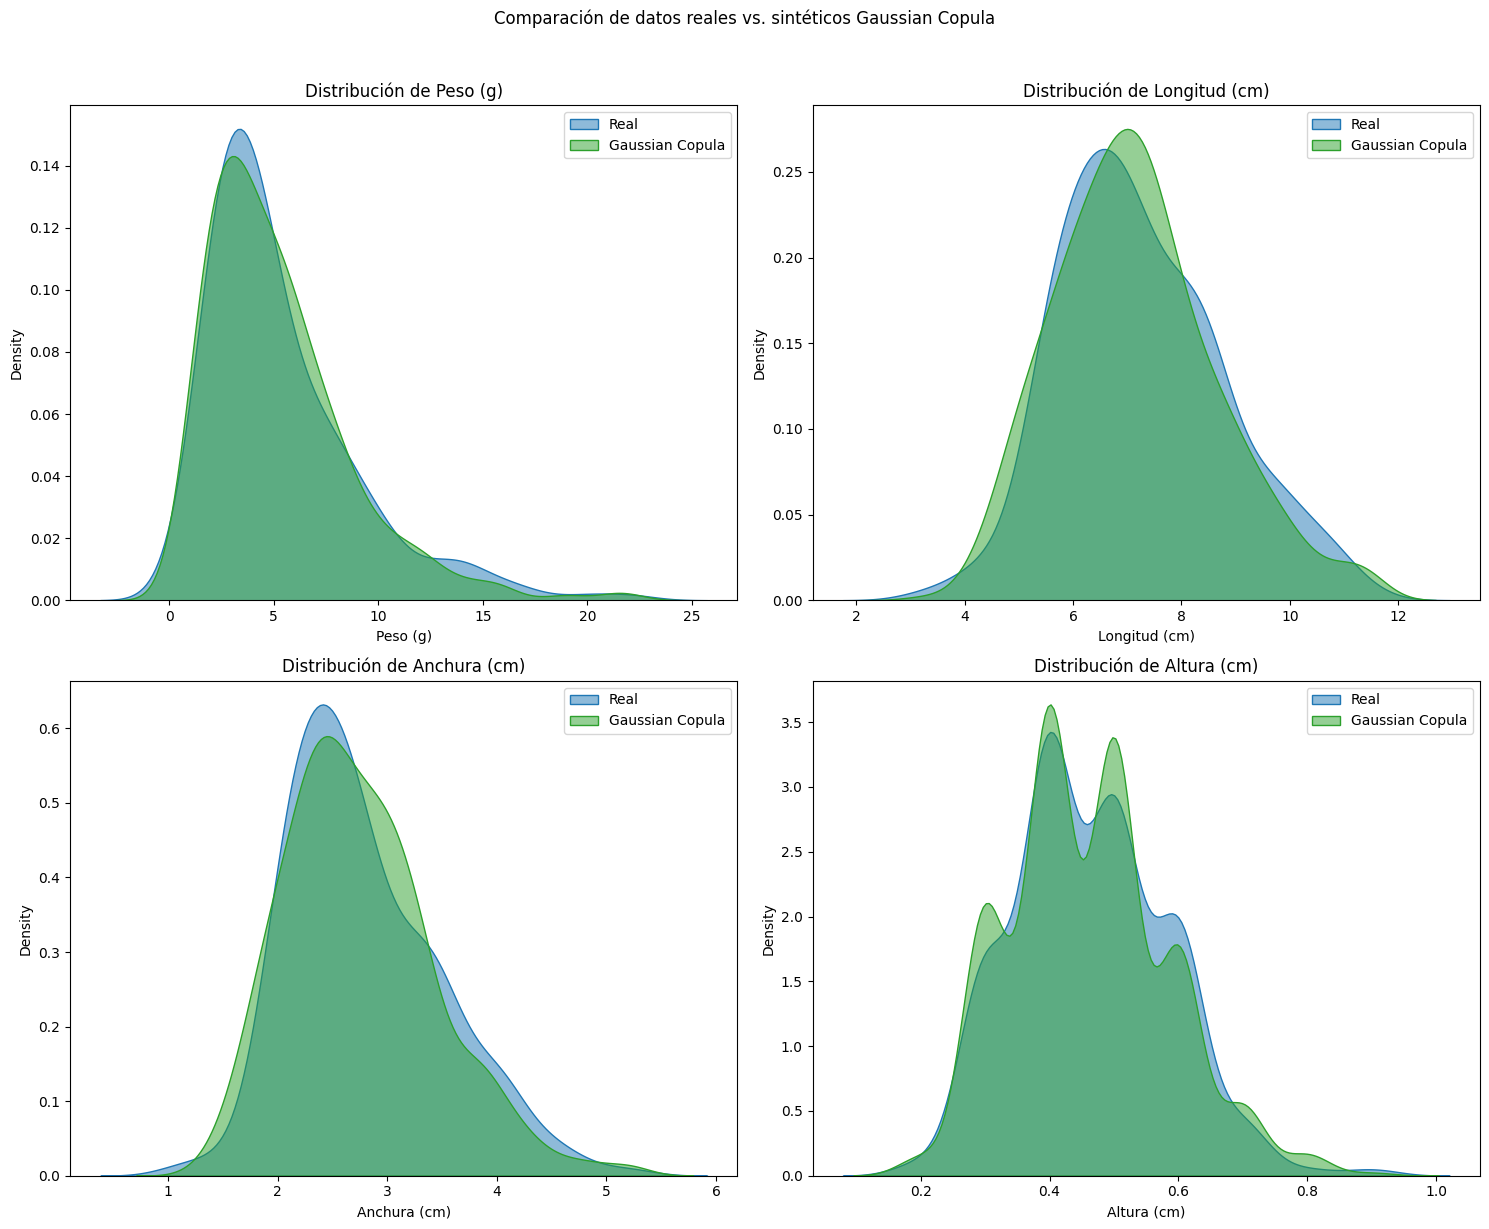


SIMILITUD ESTADÍSTICA

Overall score: 96.26%


Resultados de ajuste real vs. sintético por columna de datos

          Column        Metric     Score
0       Peso (g)  KSComplement  0.928230
1  Longitud (cm)  KSComplement  0.928230
2   Anchura (cm)  KSComplement  0.923445
3    Altura (cm)  KSComplement  0.952153


In [3]:
## Visualización de datos

columnas = ["Peso (g)", "Longitud (cm)", "Anchura (cm)", "Altura (cm)"]

from sdv.evaluation.single_table import get_column_plot
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
for i, col in enumerate(columnas):
    ax = axs[i//2, i%2]
    sns.kdeplot(real_data[col], ax=ax, color="#1f77b4", label="Real", fill=True, alpha=0.5)
    sns.kdeplot(synthetic_data[col], ax=ax, color="#2ca02c", label="Gaussian Copula", fill=True, alpha=0.5)
    ax.set_title(f'Distribución de {col}')
    ax.legend()
plt.suptitle('Comparación de datos reales vs. sintéticos Gaussian Copula', y=1.02)
plt.tight_layout()
plt.show()

## Medidas de similiud estadística

quality_reportGC = evaluate_quality(real_data, synthetic_data.sample(n=len(real_data), random_state=42), metadata, verbose=False)

## Obtenemos el valor promedio de la similitud
overall_score = f"{quality_reportGC.get_score()*100:.2f}%"
glue("scoreGAN", overall_score, display=False); # Definimos una variable para usar en el texto markdown
print("\nSIMILITUD ESTADÍSTICA\n")
print(f"Overall score: {overall_score}\n")

## Ajuste por columna de forma individual    
print("\nResultados de ajuste real vs. sintético por columna de datos\n")
print(quality_reportGC.get_details('Column Shapes'))

Los resultados obtenidos indican un alto grado de similitud entre los datos sintéticos y reales, con una adecuación del {glue:}`scoreGAN`. La métrica `KSComplement` evalúa el grado de similitud individualmente entre cada columna real y su sintética basándose en la forma de sus distribuciones univariadas (forma, media, dispersión). Los valores obtenidos indican un elevado grado de ajuste entre los datos reales y sintéticos, tal y como también se puede apreciar en las gráficas anteriores.

La siguiente tabla recoge la correlación entre pares de columnas numéricas y determina el grado de similitud entre los datos reales y sintéticos (`CorrelationSimilarity`), comparando específicamente las tendencias en sus distribuciones en 2D. Como se desprende de los valores obtenidos, los porcentajes de correlación son, en la mayoría de los casos, $\approx 1$, lo cual garantiza la validad de los datos sintéticos obtenidos 

In [4]:
print("\n Correlaciones entre variables real vs. sintética\n")
print(quality_reportGC.get_details('Column Pair Trends'))
print("\n")


 Correlaciones entre variables real vs. sintética

        Column 1       Column 2                 Metric     Score  \
0       Peso (g)  Longitud (cm)  CorrelationSimilarity  0.995288   
1       Peso (g)   Anchura (cm)  CorrelationSimilarity  0.998695   
2       Peso (g)    Altura (cm)  CorrelationSimilarity  0.987698   
3  Longitud (cm)   Anchura (cm)  CorrelationSimilarity  0.999846   
4  Longitud (cm)    Altura (cm)  CorrelationSimilarity  0.983536   
5   Anchura (cm)    Altura (cm)  CorrelationSimilarity  0.987907   

   Real Correlation  Synthetic Correlation  
0          0.932951               0.942375  
1          0.942354               0.939745  
2          0.861768               0.837164  
3          0.936674               0.936982  
4          0.870165               0.837236  
5          0.842673               0.818487  


